# Trends

Interesting trends.

In [1]:
# init

import datetime
import os.path
import sys

sys.path.append(os.path.abspath(".."))

from matplotlib import pyplot
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns

from covid19stats.common import get_bq_client

client = get_bq_client()

sns.set(style="darkgrid")

a4_dims = (11.7, 8.27)

## National Trends

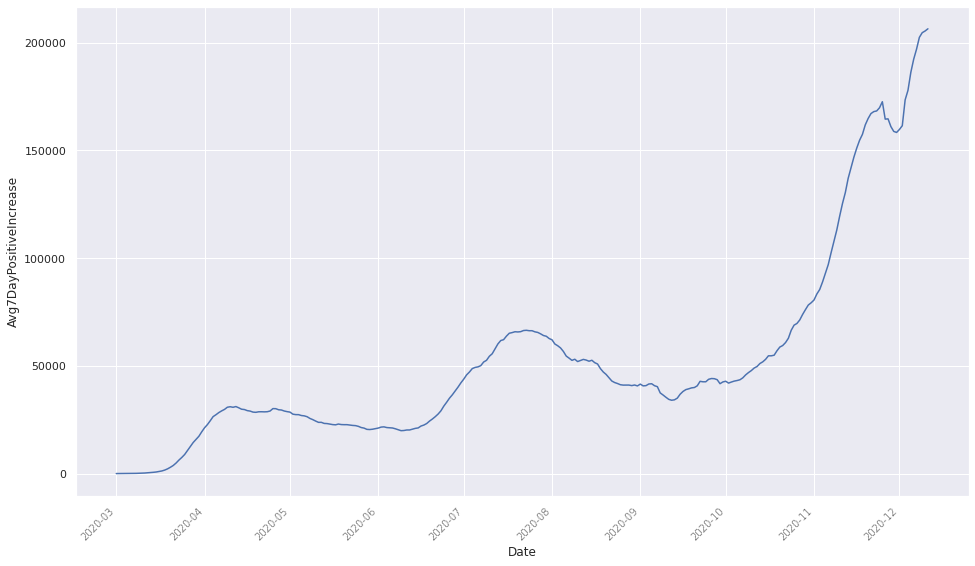

In [2]:
# plot for national trend in new cases

sql = """
    select 
        Date, Avg7DayPositiveIncrease
    from fact_nation n
    where date >= '2020-03-01'
    order by Date;
"""

job = client.query(sql)
df = job.to_dataframe()

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="Date", y="Avg7DayPositiveIncrease", data=df, ax=ax)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);

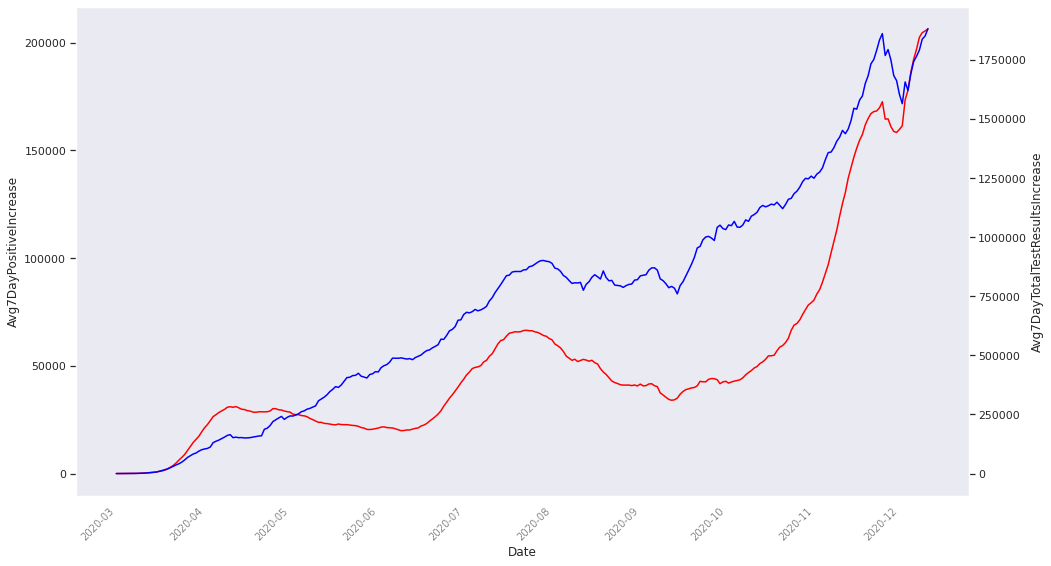

In [3]:
# compare total test results with new cases

sql = """
    select 
        Date, Avg7DayPositiveIncrease, Avg7DayTotalTestResultsIncrease
    from fact_nation n
    where date >= '2020-03-01'
    order by Date;
"""

df = client.query(sql).to_dataframe()

sns.set(style="dark")

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="Date", y="Avg7DayPositiveIncrease", data=df, ax=ax, color='red')

# for index, label in enumerate(ax.xaxis.get_ticklabels()):
#     if index % 7 != 0:
#         label.set_visible(False)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);

ax2 = ax.twinx()

chart = sns.lineplot(x="Date", y="Avg7DayTotalTestResultsIncrease", data=df, ax=ax2, color='blue')

# needed to avoid scientific notation on this y-axis
pyplot.ticklabel_format(style='plain', axis='y')

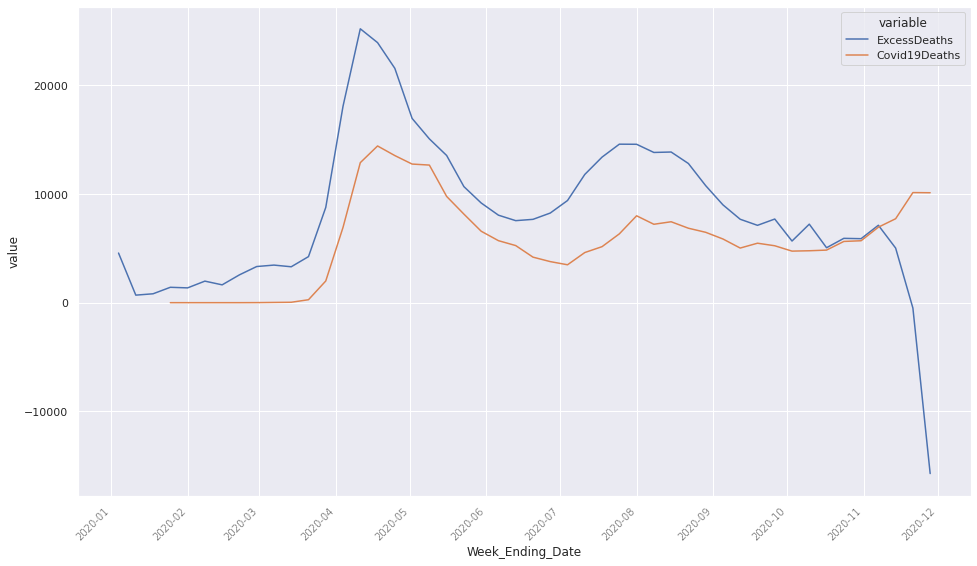

In [4]:
# compare reported covid-19 deaths with excess deaths

sql = """
    select 
        Week_Ending_Date, SUM(Excess) as ExcessDeaths, SUM(Covid19DeathsForWeek) as Covid19Deaths
    from fact_state_deaths
    group by Week_Ending_Date
    order by Week_Ending_Date;
"""

df = client.query(sql).to_dataframe()

df = pd.melt(df, id_vars=['Week_Ending_Date'])

sns.set(style="darkgrid")

fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

chart = sns.lineplot(x="Week_Ending_Date", y="value", hue="variable", data=df, ax=ax)

pyplot.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
);

## State Trends

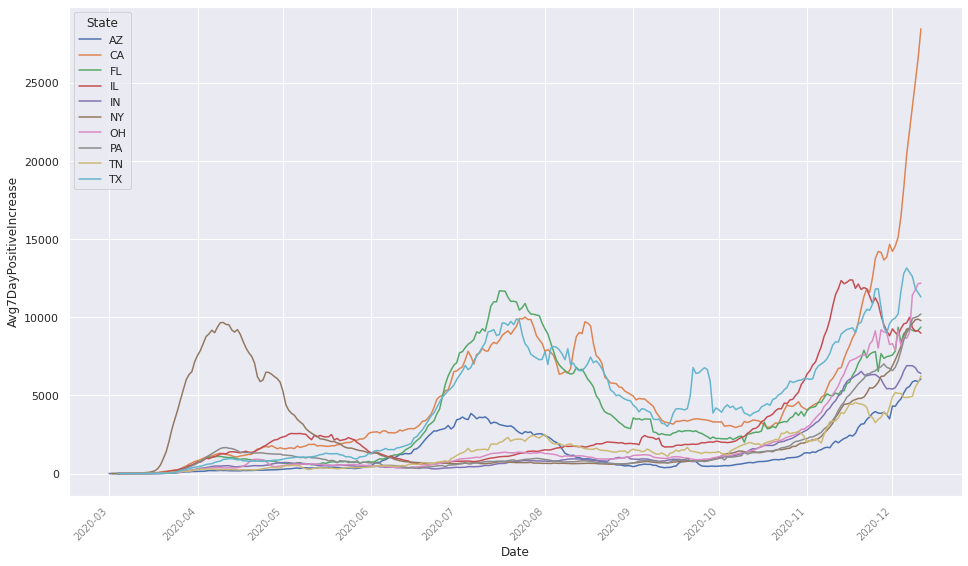

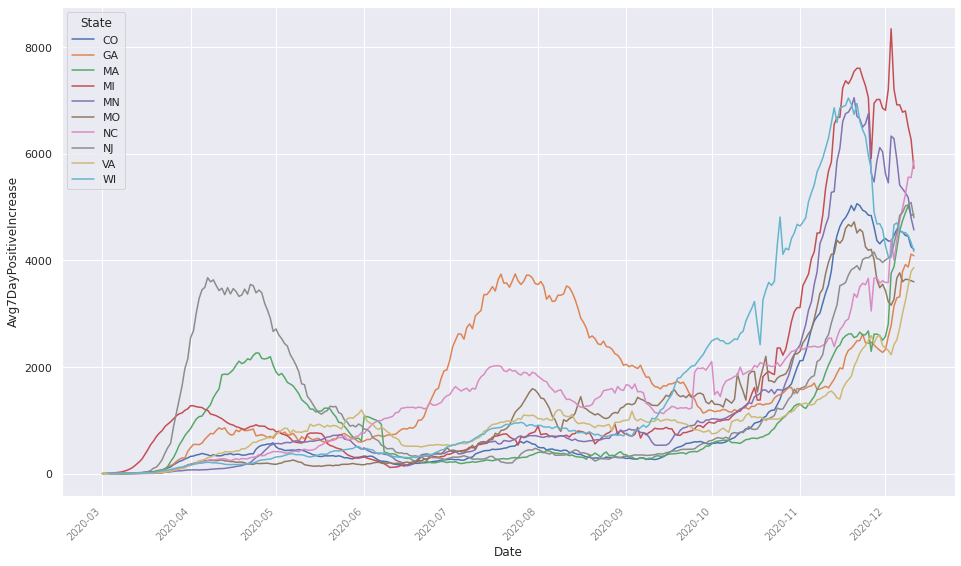

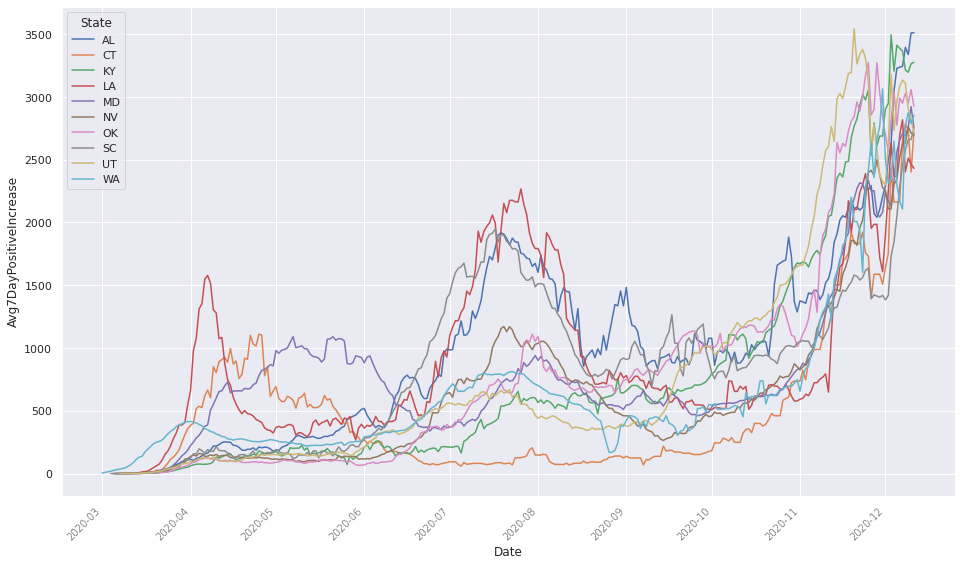

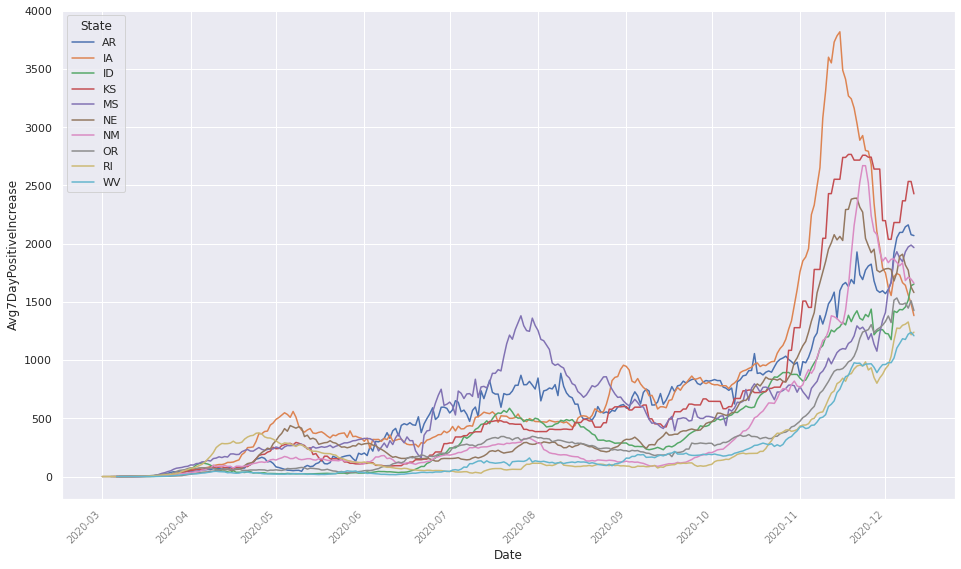

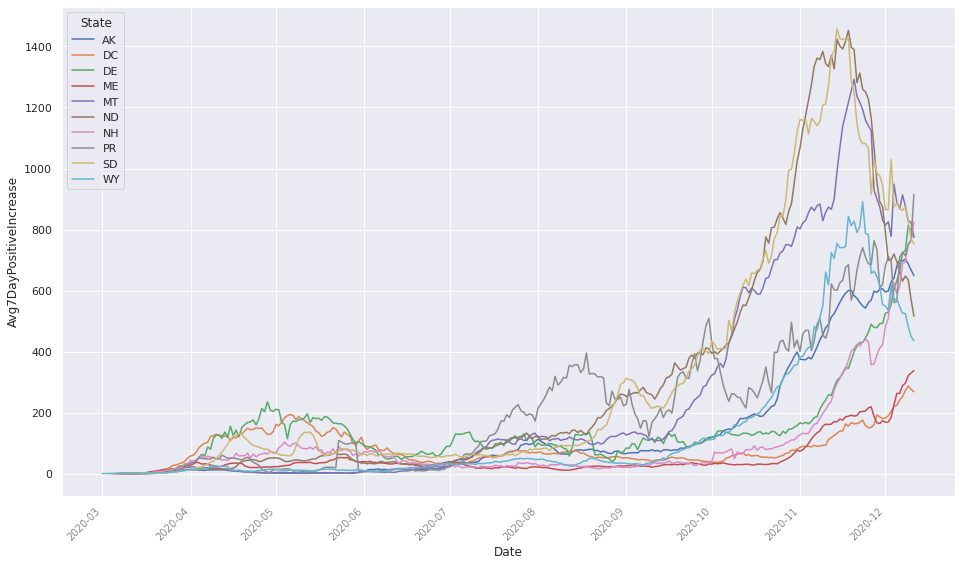

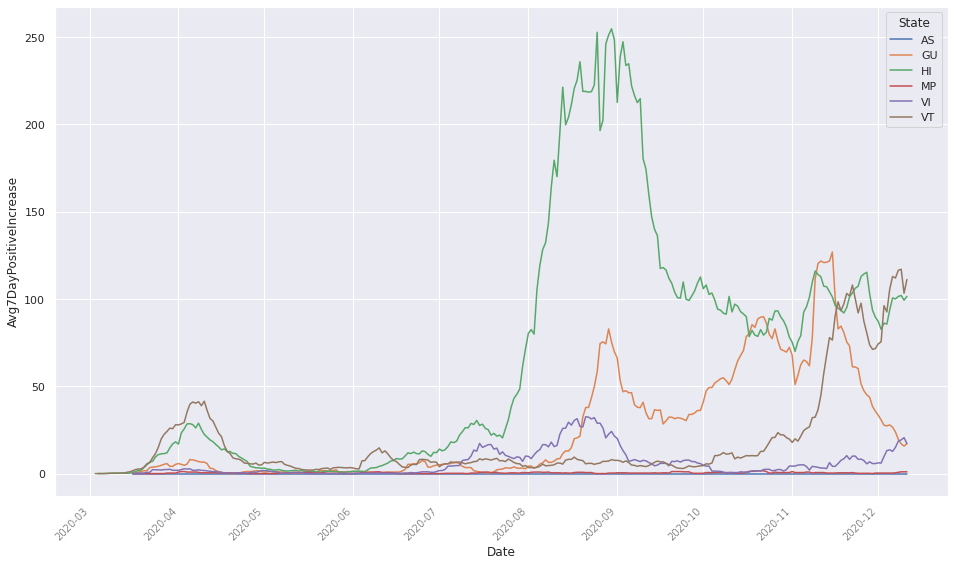

In [5]:
# show all states, split up by groups of 10, ordered by the largest most recent avg 7 day positive increase.

sql = """
   select 
        State, Avg7DayPositiveIncrease
    from fact_states
    where date = (select max(date) from fact_states)
    order by Avg7DayPositiveIncrease desc
"""

sorted = client.query(sql).to_dataframe()

sql = """
    select 
        Date, State, Avg7DayPositiveIncrease
    from fact_states
    where date >= '2020-03-01'
    order by state, Date
"""

df = client.query(sql).to_dataframe()

i = 0
chunksize = 10
while i < len(sorted):
    group = sorted[i:i+chunksize]['State'].tolist()

    subset = df[df['State'].isin(group)]

    fig, ax = pyplot.subplots(1, 1, figsize=[16, 9])

    chart = sns.lineplot(x="Date", y="Avg7DayPositiveIncrease", hue="State", data=subset, ax=ax)

    pyplot.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='small'
    );    

    i = i + chunksize


In [6]:
# how current rates of infection compare to record highs.
# sorted by long how ago the record high was (top of chart = record high is more recent)

sql = """
WITH ranked AS ( 
    SELECT 
        *
        ,ROW_NUMBER() OVER (PARTITION BY state ORDER BY avg7daypositiveincrease DESC) as RN
    FROM fact_states
)
,recordhigh AS (
    SELECT
        state,
        date as RecordHighDate,
        avg7daypositiveincrease as RecordHigh
    FROM ranked
    WHERE RN = 1
)
,trend AS (
    SELECT
        s.state,
        s.avg7daypositiveincrease - earlier.avg7daypositiveincrease as ChangeLast2Weeks
    FROM fact_states s
    JOIN fact_states earlier
        ON s.state = earlier.state
        AND s.date = DATE_ADD(earlier.date, interval 14 day)
    WHERE
        s.date = (select max(date) from fact_states)
)
SELECT
    fact_states.date,
    fact_states.state,
    fact_states.avg7daypositiveincrease,
    recordhigh.RecordHighDate,
    recordhigh.RecordHigh,
    fact_states.avg7daypositiveincrease - recordhigh.RecordHigh AS FromHigh,
    CASE WHEN ChangeLast2Weeks > 0 THEN '+' ELSE '' END || CAST(ChangeLast2Weeks as STRING) AS ChangeLast2Weeks,
    CASE
        WHEN ChangeLast2Weeks > 0 THEN 'Trending Up'
        ELSE 'Trending Down'
    END as TrendLast2Weeks
FROM fact_states 
JOIN recordhigh
    on fact_states.state = recordhigh.state
JOIN trend
    on fact_states.state = trend.state
WHERE
    date = (select max(date) from fact_states)
ORDER BY
    recordhighdate desc
"""

df = client.query(sql).to_dataframe()

df

,date,state,avg7daypositiveincrease,RecordHighDate,RecordHigh,FromHigh,ChangeLast2Weeks,TrendLast2Weeks
0,2020-12-11,AL,3510.857143,2020-12-11,3510.857143,0.000000,+1439.2857142857142,Trending Up
1,2020-12-11,AZ,6058.714286,2020-12-11,6058.714286,0.000000,+2209.8571428571427,Trending Up
2,2020-12-11,CA,28449.428571,2020-12-11,28449.428571,0.000000,+14299.142857142859,Trending Up
3,2020-12-11,ID,1653.285714,2020-12-11,1653.285714,0.000000,+435.42857142857133,Trending Up
4,2020-12-11,NC,5869.857143,2020-12-11,5869.857143,0.000000,+2203.0000000000005,Trending Up
5,2020-12-11,OH,12178.000000,2020-12-11,12178.000000,0.000000,+2980.1428571428569,Trending Up
6,2020-12-11,PA,10204.857143,2020-12-11,10204.857143,0.000000,+3372.2857142857147,Trending Up
7,2020-12-11,SC,2744.714286,2020-12-11,2744.714286,0.000000,+1322,Trending Up
8,2020-12-11,TN,6236.285714,2020-12-11,6236.285714,0.000000,+2638.5714285714289,Trending Up
9,2020-12-11,VA,3865.428571,2020-12-11,3865.428571,0.000000,+1420.7142857142858,Trending Up


In [7]:
# Confirmed COVID deaths compared to Excess Deaths
#
# Excess deaths = number of deaths above the avg deaths
# from 2014 - 2019 for the same week-ending period. There are
# more sophisticated ways to calculate excess deaths
# but this was the easiest.
#
# This is a better measure of the total impact of COVID
# than just deaths from COVID.
#
# CDC data is updated every week and past weeks do get updated,
# so we only calculate up to 2 months ago.

sql = """
WITH weeks AS (
  select distinct 
      Week_Ending_Date
  from models.fact_state_deaths
)
,latest_lagged as (
  select
      Week_Ending_Date
  from (
    select
      *,
      row_number() over (order by Week_Ending_Date desc) as ranked
    from weeks
  ) t
  where ranked = 8
)
,by_state AS (
  select 
    State,
    MIN(d.Week_Ending_Date) as StartWeek,
    MAX(d.Week_Ending_Date) as EndingWeek,
    AVG(Covid19DeathsForWeek) as AvgCovid19DeathsPerWk,
    AVG(Excess) as AvgExcessDeathsPerWk
  from models.fact_state_deaths d
  cross join latest_lagged 
  where
    d.Week_Ending_Date <= latest_lagged.Week_Ending_Date
    and d.Week_Ending_Date >= date '2020-03-01'
  group by State 
)
select
  State,
  StartWeek,
  EndingWeek,
  AvgCovid19DeathsPerWk,
  AvgExcessDeathsPerWk,
  AvgExcessDeathsPerWk - AvgCovid19DeathsPerWk as Diff,
  (AvgExcessDeathsPerWk - AvgCovid19DeathsPerWk) / AvgCovid19DeathsPerWk * 100 AS DiffPct
from by_state
order by DiffPct desc
"""

df = client.query(sql).to_dataframe()

df

,State,StartWeek,EndingWeek,AvgCovid19DeathsPerWk,AvgExcessDeathsPerWk,Diff,DiffPct
0,Wyoming,2020-03-07,2020-10-10,1.68750,14.270833,12.583333,745.679012
1,Vermont,2020-03-07,2020-10-10,1.81250,9.916667,8.104167,447.126437
2,Maine,2020-03-07,2020-10-10,4.46875,19.859375,15.390625,344.405594
3,Alaska,2020-03-07,2020-10-10,1.87500,8.171875,6.296875,335.833333
4,Oregon,2020-03-07,2020-10-10,18.71875,70.984375,52.265625,279.215359
5,Utah,2020-03-07,2020-10-10,15.93750,58.953125,43.015625,269.901961
6,Montana,2020-03-07,2020-10-10,6.53125,20.401042,13.869792,212.360447
7,Wisconsin,2020-03-07,2020-10-10,45.87500,139.250000,93.375000,203.542234
8,Kentucky,2020-03-07,2020-10-10,39.03125,118.151042,79.119792,202.708834
9,Tennessee,2020-03-07,2020-10-10,86.18750,256.223958,170.036458,197.286681
